First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [ ]:
# SSL FIX FOR macOS + Conda USERS (only necessary if CERTIFICATE_VERIFY_FAILED)
# This ensures HTTPS requests (used by the triple store engine) can verify certificates.
# If you don't have SSL issues, you can skip this cell.

import ssl, certifi

def _bi2025_https_context(*args, **kwargs):
    # always create a context using certifi's CA bundle
    return ssl.create_default_context(cafile=certifi.where())

ssl._create_default_https_context = _bi2025_https_context

In [1]:
# !conda create -n BI2025 python=3.11 -y
!conda activate BI2025
!pip install -r requirements.txt

Der Befehl "conda" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "pip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

In [3]:
import seaborn as sns

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [4]:
executed_by ='stud-id_52110660'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [5]:
# group id for this project
group_id = '045'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_52110660'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12119884'  # Replace the digits after "id_" with student B's student ID

In [6]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [7]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [8]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [9]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [10]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Jan" .',
f':{student_a} foaf:familyName "Morawez" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "52110660"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Monika" .',
f':{student_b} foaf:familyName "Vedral" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12119884"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [11]:
weather_data_path = os.path.join("data", "datasets", "weather")
cyclists_data_path = os.path.join("data", "datasets", "cyclists")

## Business Understanding 

In [12]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [13]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
The data set originates from the SUPPORT (Study to Understand Prognoses and Preferences
for Outcomes and Risks of Treatments) clinical study, conducted between 1989 and 1994 in five
US hospitals. It was released by the Vanderbilt University Department of Biostatistics (Prof.
Frank Harrell, 2022) and contains 9,105 real-world clinical patient records.
The original SUPPORT study aimed to improve end-of-life decision-making by providing
physicians with an improved prognostic model to predict survival for seriously ill patients.
Phase I (1989–1991) developed and validated a prognostic model for 180-day survival. Phase
II (1992–1994) compared predictions from this model against existing prognostic systems and
physicians’ subjective estimates. The dataset includes demographics, diagnoses, disease categories,
comorbidities, physiologic measurements, and outcomes such as survival time, hospital
death, and hospital length of stay (slos).
Scenario: A hospital analysis identified that reliable bed occupancy forecasts are missing.
This uncertainty makes it difficult to plan admissions, schedule staff, and coordinate patient
transfers. Current forecasts of patient length of stay, which rely on averages and physician judgment,
are insufficient. By improving hospital length of stay (LOS) prediction for new patients,
managers can better anticipate bed availability, allocate staff efficiently, and steer operational
processes.
"""

business_objectives_comment = """
Although the original study focused on survival prediction, for this scenario the objective is
repurposed to develop a predictive model that estimates the hospital length of stay (in days) for
incoming patients.
SMART Objective: Improve hospital capacity planning and resource allocation by predicting
patient length of stay at or shortly after admission more accurately with available data.
"""

business_success_criteria_comment = """
The project is successful if the predictive model leads to measurable improvements in hospital
operations, such as:
1. Improvement in bed occupancy forecasts compared to current average based methods.
2. Improved ability of management to plan staff schedules and allocate resources efficiently.
3. Enhanced operational efficiency and patient flow, reducing bottlenecks and costly rescheduling.
The primary judge of success is hospital management and operations staff.
"""

data_mining_goals_comment = """
The data mining goal is to build a regression model that predicts hospital length of stay
(LOS) using patient demographics, diagnoses, and clinical variables such as neurological and
physiological indicators.
Output: LOS prediction in days until discharge or death, equivalent to the time until the
hospital bed becomes available again.
"""

data_mining_success_criteria_comment = """
The following Success Criteria were defined:
1. Primary metric (average error in days): Mean Absolute Error (MAE) ≤ 3 days (baseline
mean predictor expected error est.: 5–6 days).
2. Secondary metrics: Root Mean Squared Error (RMSE) to penalize large errors and R²
≥ 0.5 to measure explained variance.
3. Benchmarks: Compare against baseline (predicting mean or median LOS).
4. Interpretability: Identify and explain the most important predictors of LOS (e.g., age,
disease group, comorbidities).
"""

ai_risk_aspects_comment = """
The following risks and considerations were identified:
1. Regulatory: LOS prediction is classified as high-risk AI under the EU AI Act. Deployment
requires risk management, documentation, transparency, and human oversight. Model must be deployable in hospital IT infrastructure and compliant with
EU AI regulations.
2. Bias: The model may underperform for certain subgroups (e.g., by age, disease type,
comorbidity count, or underrepresented diagnoses). Bias and fairness must be evaluated.
3. Ethics: Predictions should support staff and not replace clinical judgment or be misused.
A human-in-the-loop is required to ensure ethical alignment.
4. Data Drift: SUPPORT data was collected 1989–1994. Clinical practices and patient populations
have changed, so retraining on modern data would be required before deployment.
Business Intelligence Assignment 2 3
5. Privacy: Patient data is highly sensitive. Even though SUPPORT is de-identified, realworld
deployment must comply with GDPR and other legal privacy frameworks.
6. Explainability: Hospitals require interpretable models (e.g., regression coefficients,
feature importance, SHAP values) to build trust and ensure usability.
"""


bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [14]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(data_understanding_phase_executor, prefixes=prefixes)


# Task 2: Loading our data

In [15]:
# Path
root = os.path.dirname(os.path.abspath(os.getcwd()))
support2_data_path = os.path.join(root, "data", "support2_cf.csv")

load_support2_data_code_writer = student_a
def load_support2_data(path)-> pd.DataFrame:

    ### Load your data
    df = pd.read_csv(path, sep=";")
    
    return df

start_time_ld = now()
data = load_support2_data(support2_data_path)
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c" # Generate once
load_support2_data_executor = [
    f':load_support2_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_support2_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" # Generate once
ld_report = """
Full report missing! .... load all support2 data
"""
load_support2_data_activity = [
    ':load_support2_data rdf:type prov:Activity .',
    ':load_support2_data sc:isPartOf :data_understanding_phase .',
    ':load_support2_data rdfs:comment \'Data Understanding\' .',
    f':load_support2_data rdfs:comment """{ld_report}""" .', 
    f':load_support2_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_support2_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_support2_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_support2_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_support2_data prov:used :raw_data .',
    ':load_support2_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_support2_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_support2_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Support2 data set\' .',
    ':raw_data sc:description \'DESCRIPTION of the data set.\' .',
    # Continue with futher information about the dataset...
    ':support2_csv rdf:type cr:FileObject .',
    ':support2_csv sc:name \'support2_cf.csv\' .',
    ':support2_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :support2_csv .',
    # Continue with further information about the distribution...
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table (distribution, granularity, detailed description) of support2 study data\' .',
    ':raw_recordset cr:source :support2_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
    # Continue with further information about the recordset...
    ':raw_recordset cr:field :field_date .',
    ':raw_recordset cr:field :field_number .',
    ':field_date rdf:type cr:Field .',
    ':field_date sc:name \'date\' .',
    ':field_date sc:description \'This is a date field of...\' .',
    ':field_date cr:dataType xsd:dateTime .',
    # Continue with futher information about the field...
    ':field_number rdf:type cr:Field .',
    ':field_number sc:name \'number\' .',
    ':field_number sc:description \'This field describes..\' .',
    ':field_number cr:dataType xsd:integer .',
    # Continue with futher fields...
]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':data rdf:type sc:Dataset .',
    # ...
    ':recordset rdf:type cr:RecordSet .',
    # ...
    ':data cr:recordSet :recordset .',
    # ...
    # Fields can also be reused
    ':recordset cr:field :field_date .',
    ':recordset cr:field :field_number .',
    # The loaded data has additional fields
    ':recordset cr:field :field_day_of_week .',
    ':field_day_of_week rdf:type cr:Field .',
    ':field_day_of_week sc:name \'day_of_week\' .',
    ':field_day_of_week sc:description \'Day of week description\' .',
    ':field_day_of_week cr:dataType xsd:string .',
    # This is not actually a field in the dataframe but below demonstrates how units may be used
    ':recordset cr:field :field_temp .', 
    ':field_temp rdf:type cr:Field .',
    ':field_temp sc:name \'temperature\' .',
    ':field_temp sc:description \'Description Temperature\' .',
    ':field_temp cr:dataType xsd:double .',
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    ':field_number qudt:unit qudt:CountingUnit .',
    ':field_temp qudt:unit siu:degree_Celsius .',
]
engine.insert(units_triples, prefixes=prefixes)

,Unnamed: 0,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,...,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
0,1,62.84998,0,male,0,5,2029,Lung Cancer,Cancer,0,...,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,NaN,7.0
1,2,60.33899,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,...,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,<2 mo. follow-up,1.0
2,3,52.74698,1,female,0,17,47,Cirrhosis,COPD/CHF/Cirrhosis,2,...,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0,<2 mo. follow-up,0.0
3,4,42.38498,1,female,0,3,133,Lung Cancer,Cancer,2,...,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0,no(M2 and SIP pres),0.0
4,5,79.88495,0,female,0,16,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,...,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0,no(M2 and SIP pres),2.0


## Task 2a: Attribute overview

In [16]:
#############################################
# Dictionaries of 2 a
#############################################

semantics_dict = {
    "id": "id",
    "age": "continuous",
    "death": "outcome",           # death by NDI follow-up (post-admission outcome)
    "sex": "categorical",
    "hospdead": "outcome",        # in-hospital death (post-admission outcome)
    "slos": "target",             # hospital length of stay (days)
    "d.time": "outcome",          # days of follow-up (time-to-event/censoring)
    "dzgroup": "categorical",     # 9-level disease subgroup
    "dzclass": "categorical",     # 4-level disease class
    "num.co": "ordinal",          # number of comorbidities (count; treat as ordinal/continuous)
    "edu": "continuous",          # years of education
    "income": "categorical",      # 4-level income bracket
    "scoma": "score",             # SUPPORT coma score (based on Glasgow)
    "charges": "cost",
    "totcst": "cost",
    "totmcst": "cost",
    "avtisst": "score",           # Average TISS (days 3–25)
    "race": "categorical",        # 5-level race/ethnicity
    "sps": "score",               # SUPPORT physiology score (day 3)
    "aps": "score",               # APS III (day 3)
    "surv2m": "prognostic_day3",  # model survival prediction at day 3 (derived)
    "surv6m": "prognostic_day3",  # model survival prediction at day 3 (derived)
    "hday": "continuous",         # hospital day at study admit
    "diabetes": "categorical",    # comorbidity indicator
    "dementia": "categorical",    # comorbidity indicator
    "ca": "categorical",          # cancer status: no/yes/metastatic
    "prg2m": "clinician_estimate",# MD 2-month survival estimate (subjective)
    "prg6m": "clinician_estimate",# MD 6-month survival estimate (subjective)
    "dnr": "policy",              # DNR status (no/before/after study admit)
    "dnrday": "policy_time",      # days to DNR (neg = before study)
    "meanbp": "physio_day3",      # mean arterial blood pressure (day 3)
    "wblc": "physio_day3",        # white blood cell count (day 3)
    "hrt": "physio_day3",         # heart rate (day 3)
    "resp": "physio_day3",        # respiration rate (day 3)
    "temp": "physio_day3",        # temperature C (day 3)
    "pafi": "physio_day3",        # PaO2/(0.01*FiO2) (day 3)
    "alb": "physio_day3",         # serum albumin (day 3)
    "bili": "physio_day3",        # bilirubin (day 3)
    "crea": "physio_day3",        # serum creatinine (day 3)
    "sod": "physio_day3",         # sodium (day 3)
    "ph": "physio_day3",          # arterial pH (day 3)
    "glucose": "physio_day3",     # glucose (day 3)
    "bun": "physio_day3",         # blood urea nitrogen (day 3)
    "urine": "physio_day3",       # urine output (day 3)
    "adlp": "function_score",     # activities of daily living: patient (day 3)
    "adls": "function_score",     # ADL surrogate (day 3)
    "sfdm2": "outcome",           # functional disability at 2 months (5-level outcome)
    "adlsc": "function_score"     # imputed ADL calibrated to surrogate
}

description_dict = {
    "id": "Patient identifier.",
    "age": "Age in years at study entry.",
    "death": "Death at any time up to National Death Index (NDI) date 31-Dec-1994.",
    "sex": "Sex of patient (male/female).",
    "hospdead": "Death in hospital during index stay.",
    "slos": "Days from study entry to discharge (length of stay).",
    "d.time": "Days of follow-up from study entry.",
    "dzgroup": "Disease subgroup: ARF/MOSF w/Sepsis, COPD, CHF, Cirrhosis, Coma, Colon Cancer, Lung Cancer, MOSF w/Malignancy.",
    "dzclass": "Disease class: ARF/MOSF; COPD/CHF/Cirrhosis; Coma; Cancer.",
    "num.co": "Number of comorbid conditions.",
    "edu": "Years of formal education.",
    "income": "Household income bracket (under $11k; $11–$25k; $25–$50k; >$50k).",
    "scoma": "SUPPORT coma score based on Glasgow (Day 3).",
    "charges": "Hospital charges for the stay.",
    "totcst": "Total RCC cost.",
    "totmcst": "Total micro-cost.",
    "avtisst": "Average Therapeutic Intervention Scoring System (TISS), Days 3–25.",
    "race": "Race/ethnicity (white, black, asian, other, hispanic).",
    "sps": "SUPPORT physiology score (Day 3).",
    "aps": "APS III (no coma; adjustments per study) (Day 3).",
    "surv2m": "Model-predicted 2-month survival at Day 3.",
    "surv6m": "Model-predicted 6-month survival at Day 3.",
    "hday": "Hospital day at study admission.",
    "diabetes": "Diabetes comorbidity indicator.",
    "dementia": "Dementia comorbidity indicator.",
    "ca": "Cancer status (no/yes/metastatic).",
    "prg2m": "Physician’s 2-month survival estimate (subjective).",
    "prg6m": "Physician’s 6-month survival estimate (subjective).",
    "dnr": "Do-Not-Resuscitate status (no DNR; DNR before study admit; DNR after study admit).",
    "dnrday": "Days to DNR order (negative if before study entry).",
    "meanbp": "Mean arterial blood pressure (Day 3).",
    "wblc": "White blood cell count (Day 3).",
    "hrt": "Heart rate (Day 3).",
    "resp": "Respiratory rate (Day 3).",
    "temp": "Temperature in Celsius (Day 3).",
    "pafi": "PaO2/(0.01×FiO2) ratio (Day 3).",
    "alb": "Serum albumin (Day 3).",
    "bili": "Serum bilirubin (Day 3).",
    "crea": "Serum creatinine (Day 3).",
    "sod": "Serum sodium (Day 3).",
    "ph": "Arterial pH (Day 3).",
    "glucose": "Serum glucose (Day 3).",
    "bun": "Blood urea nitrogen (Day 3).",
    "urine": "Urine output (Day 3).",
    "adlp": "Activities of daily living score (patient self-report, Day 3).",
    "adls": "Activities of daily living score (surrogate, Day 3).",
    "sfdm2": "Functional disability at 2 months (5-level scale).",
    "adlsc": "Imputed ADL calibrated to surrogate."
}

ethical_dict = {
    "id": "no",
    "age": "yes",        # age is sensitive for fairness considerations
    "death": "yes",      # mortality outcome is highly sensitive
    "sex": "yes",
    "hospdead": "yes",
    "slos": "no",
    "d.time": "yes",
    "dzgroup": "no",
    "dzclass": "no",
    "num.co": "no",
    "edu": "yes",        # socioeconomic / education
    "income": "yes",     # socioeconomic / income
    "scoma": "yes",      # neurological/mental status implication
    "charges": "yes",    # financial/cost data
    "totcst": "yes",
    "totmcst": "yes",
    "avtisst": "no",
    "race": "yes",       # protected attribute
    "sps": "no",
    "aps": "no",
    "surv2m": "yes",     # prognostic values; sensitive outcome-related
    "surv6m": "yes",
    "hday": "no",
    "diabetes": "yes",   # health condition
    "dementia": "yes",   # mental/cognitive health
    "ca": "yes",         # cancer status
    "prg2m": "yes",      # clinician judgment about survival
    "prg6m": "yes",
    "dnr": "yes",        # end-of-life preference/order
    "dnrday": "yes",
    "meanbp": "no",
    "wblc": "no",
    "hrt": "no",
    "resp": "no",
    "temp": "no",
    "pafi": "no",
    "alb": "no",
    "bili": "no",
    "crea": "no",
    "sod": "no",
    "ph": "no",
    "glucose": "no",
    "bun": "no",
    "urine": "no",
    "adlp": "yes",       # functional status
    "adls": "yes",       # functional status (surrogate)
    "sfdm2": "yes",      # disability/mortality at 2 months
    "adlsc": "yes"       # imputed functional status
}

units_dict = {
    # Outcomes / time-to-event
    "slos": "days",                      # study entry → discharge (length of stay)
    "d.time": "days",                    # days of follow-up from study entry
    "death": "binary indicator",         # 0/1 death during follow-up
    "hospdead": "binary indicator",      # 0/1 death in hospital during index stay
    "sfdm2": "ordinal score (1–5)",      # functional disability category at 2 months

    # Costs
    "charges": "US dollars",             # hospital charges for stay
    "totcst": "US dollars",              # total RCC cost
    "totmcst": "US dollars",             # total micro-cost

    # IDs & demographics / categorical
    "id": "identifier",                  # patient ID (no physical unit)
    "ca": "categorical (cancer status)", # no/yes/metastatic
    "dementia": "binary indicator",      # 0/1 comorbidity
    "diabetes": "binary indicator",      # 0/1 comorbidity
    "dzclass": "categorical (disease class)",
    "dzgroup": "categorical (disease subgroup)",
    "income": "ordinal income bracket",  # income category
    "race": "categorical (race/ethnicity)",
    "sex": "categorical (sex)",
    "num.co": "count",                   # number of comorbid conditions

    # Baseline continuous demographics / time
    "age": "years",                      # age at study entry
    "edu": "years",                      # years of formal education
    "hday": "days",                      # hospital day of study admit

    # Scores
    "aps": "APACHE III score (dimensionless)",
    "avtisst": "TISS score (dimensionless)",
    "scoma": "SUPPORT coma score (dimensionless)",
    "sps": "SUPPORT physiology score (dimensionless)",

    # Lab / physiologic day 3
    "alb": "g/dL",                       # serum albumin
    "bili": "mg/dL",                     # serum bilirubin
    "bun": "mg/dL",                      # blood urea nitrogen
    "crea": "mg/dL",                     # serum creatinine
    "glucose": "mg/dL",                  # serum glucose
    "hrt": "beats/min",                  # heart rate
    "meanbp": "mmHg",                    # mean arterial blood pressure
    "pafi": "mmHg",                      # PaO2/(0.01×FiO2) ratio (pressure)
    "ph": "dimensionless (pH)",          # logarithmic hydrogen ion concentration
    "resp": "breaths/min",               # respiratory rate
    "sod": "mEq/L",                      # serum sodium concentration
    "temp": "°C",                        # body temperature
    "urine": "mL/day",                   # urine output per 24h
    "wblc": "10^3 cells/µL",             # white blood count (thousands)

    # Function / ADL scores
    "adlp": "ADL score (patient, dimensionless)",
    "adls": "ADL score (surrogate, dimensionless)",
    "adlsc": "ADL score (calibrated, dimensionless)",

    # Prognostic model outputs / probabilities
    "surv2m": "probability (0–1)",       # SUPPORT model 2-month survival estimate
    "surv6m": "probability (0–1)",       # SUPPORT model 6-month survival estimate
    "prg2m": "probability (0–1)",        # physician 2-month survival estimate
    "prg6m": "probability (0–1)",        # physician 6-month survival estimate

    # Policy variables
    "dnr": "categorical (code for DNR status)",
    "dnrday": "days",                    # days to DNR order (negative if before study entry)
}

In [17]:
#############################################
# create attribute overview
#############################################

get_attribute_overview_code_writer = student_a

def get_attribute_overview(df, semantics_dict, description_dict, units_dict):
    overview = pd.DataFrame({
        "Attribute": df.columns,
        "Tech type": df.dtypes.astype(str).values,
    })

    overview["Semantic type"] = overview["Attribute"].map(semantics_dict).fillna("unknown")
    overview["Unit"] = overview["Attribute"].map(units_dict).fillna("N/A")
    overview["Description"] = overview["Attribute"].map(description_dict).fillna("No description available")

    return overview

start_time_ao = now()
attribute_overview = get_attribute_overview(data, semantics_dict, description_dict, units_dict)
end_time_ao = now()

# readability improvements: sort for readability (target/outcome first, then others)
disp = attribute_overview.copy()

sort_order = {"target": 0, "outcome": 1, "cost": 2, "id": 3,
              "categorical": 4, "ordinal": 5, "continuous": 6,
              "score": 7, "physio_day3": 8, "function_score": 9,
              "prognostic_day3": 10, "clinician_estimate": 11,
              "policy": 12, "policy_time": 13, "unknown": 99}
disp["_order"] = disp["Semantic type"].map(sort_order).fillna(50)
disp = disp.sort_values(["_order", "Attribute"]).drop(columns=["_order"])

display(disp)


,Attribute,Tech type,Semantic type,Unit,Description
5,slos,int64,target,days,Days from study entry to discharge (length of ...
6,d.time,int64,outcome,days,Days of follow-up from study entry.
2,death,int64,outcome,binary indicator,Death at any time up to National Death Index (...
4,hospdead,int64,outcome,binary indicator,Death in hospital during index stay.
46,sfdm2,object,outcome,ordinal score (1–5),Functional disability at 2 months (5-level sca...
13,charges,float64,cost,US dollars,Hospital charges for the stay.
14,totcst,float64,cost,US dollars,Total RCC cost.
15,totmcst,float64,cost,US dollars,Total micro-cost.
25,ca,object,categorical,categorical (cancer status),Cancer status (no/yes/metastatic).
24,dementia,int64,categorical,binary indicator,Dementia comorbidity indicator.


In [18]:
#############################################
# Documentation of 2 a
#############################################

# 1. Executor
ao_ass_uuid_executor = "5f3c8b7a-9db4-4b21-9f60-2c7a3e2c41ad" # Generate once
attribute_overview_executor = [
    f':attribute_overview prov:qualifiedAssociation :{ao_ass_uuid_executor} .',
    f':{ao_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ao_ass_uuid_executor} rdf:type prov:Association .',
    f':{ao_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(attribute_overview_executor, prefixes=prefixes)

# 2. Writer
ao_ass_uuid_writer = "c2e7a9fa-4f3d-4267-9c8f-1c0c4e92f3e7"
ao_comment = """
MISSING SUMMARY
"""

# 3. Activity: create attribute overview 
attribute_overview_activity = [
    ':attribute_overview rdf:type prov:Activity .',
    ':attribute_overview sc:isPartOf :data_understanding_phase .',
    ':attribute_overview rdfs:comment \'Data Understanding\' .',
    f':attribute_overview rdfs:comment """{ao_comment}""" .', 
    f':attribute_overview prov:startedAtTime "{start_time_ao}"^^xsd:dateTime .',
    f':attribute_overview prov:endedAtTime "{end_time_ao}"^^xsd:dateTime .',
    f':attribute_overview prov:qualifiedAssociation :{ao_ass_uuid_writer} .',
    f':{ao_ass_uuid_writer} prov:agent :{get_attribute_overview_code_writer} .',
    f':{ao_ass_uuid_writer} rdf:type prov:Association .',
    f':{ao_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':attribute_overview prov:used :data .',
    ':attribute_report rdf:type prov:Entity .',
    f':attribute_report rdfs:label "Attribute Overview Report" .',
    ':attribute_report prov:wasGeneratedBy :attribute_overview .',
]
engine.insert(attribute_overview_activity, prefixes=prefixes)

# 4. Activity: Inspecting the attributes overview and taking a decision on what to do
iao_ass_uuid_executor = "7c4c9f2d-0b39-4b4e-8e3d-7d7e4a0be8cf"
iao_comment = """
After inspecting the attributes overview the following decisions have been made: ...
"""
inspect_attribute_overview_report_executor = student_a
inspect_attribute_overview_activity = [
    ':inspect_attribute_overview rdf:type prov:Activity .',
    ':inspect_attribute_overview sc:isPartOf :data_understanding_phase .',
    ':inspect_attribute_overview rdfs:comment \'Data Understanding\' .',
    f':inspect_attribute_overview rdfs:comment """{iao_comment}""" .', 
    f':inspect_attribute_overview prov:startedAtTime "{start_time_ao}"^^xsd:dateTime .',
    f':inspect_attribute_overview prov:endedAtTime "{end_time_ao}"^^xsd:dateTime .',
    f':inspect_attribute_overview prov:qualifiedAssociation :{iao_ass_uuid_executor} .',
    f':{iao_ass_uuid_executor} prov:agent :{inspect_attribute_overview_report_executor} .',
    f':{iao_ass_uuid_executor} rdf:type prov:Association .',
    f':{iao_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_attribute_overview prov:used :attribute_report .',
    ':attribute_overview_decision rdf:type prov:Entity .',
    f':attribute_overview_decision rdfs:comment """ DECISIONS !!!""" .',
    ':attribute_overview_decision prov:wasGeneratedBy :inspect_attribute_overview .',
]
engine.insert(inspect_attribute_overview_activity, prefixes=prefixes)

# Task 2b: Statistical properties

In [19]:
#############################################
# compute statistical properties
#############################################

stats_code_writer = student_a

target = "slos"

start_time_sp = now()

# add numeric sex encoding for stats
data["sex_num"] = data["sex"].map({"female": 0, "male": 1})

# distinguish data
binary_categories = ["death", "sex_num", "hospdead", "diabetes", "dementia"]
num_cols = data.select_dtypes(include=["float64", "int64"]).columns.tolist()
num_nonbinary = [c for c in num_cols if c not in binary_categories]
cat_cols = data.select_dtypes(include=["object"]).columns.tolist()

print(f"Numeric (non-binary): {len(num_nonbinary)}")
print(f"Binary variables:     {len(binary_categories)}")
print(f"Categorical:          {len(cat_cols)}")

# basic descriptive statistics for numeric data without binary vars
numeric_stats = data[num_nonbinary].describe(
    percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
).T

numeric_stats["variance"] = data[num_nonbinary].var()
numeric_stats["skewness"] = data[num_nonbinary].skew()
numeric_stats["kurtosis"] = data[num_nonbinary].kurt()

numeric_stats = numeric_stats.round(3)
print("\n numeric variable statistics")
display(numeric_stats)

# binary variable statistics
bin_stats = pd.DataFrame(index=binary_categories)
bin_stats["mean/prevalence"] = data[binary_categories].mean() # prevalence of 1
bin_stats["std"] = data[binary_categories].std()
bin_stats["var"] = data[binary_categories].var()
bin_stats["n_ones"] = data[binary_categories].sum()
bin_stats["n_zeros"] = data[binary_categories].count() - bin_stats["n_ones"]
bin_stats["%_ones"] = bin_stats["mean/prevalence"] * 100
bin_stats["%_zeros"] = 100 - bin_stats["%_ones"]

bin_stats = bin_stats.round(3)
print("\n binary variable statistics")
display(bin_stats)

# categorical variable statistics (non binary)
cat_stats = pd.DataFrame({
    "n_unique": data[cat_cols].nunique(),
    "most_frequent": data[cat_cols].apply(
        lambda s: s.value_counts().idxmax() if s.notna().any() else None
    ),
    "freq_most_frequent": data[cat_cols].apply(
        lambda s: s.value_counts().iloc[0] if s.notna().any() else 0
    ),
})

print("\n categorical variable statistics")
display(cat_stats)

# correlation structure (numeric-only)
corr_pearson = data[num_cols].corr(method="pearson")
corr_spearman = data[num_cols].corr(method="spearman")

print("\n Pearson correlation matrix:")
display(corr_pearson)

print("\n Spearman correlation matrix:")
display(corr_spearman)

# correlations with target only
corr_with_target_pearson = corr_pearson[target].sort_values(ascending=False)
corr_with_target_spearman = corr_spearman[target].sort_values(ascending=False)

print(f"\n Pearson correlation with {target}:")
display(corr_with_target_pearson)

print(f"\n Spearman correlation with {target}:")
display(corr_with_target_spearman)

# target variable distribution
print(f"\n'{target}' distribution:")
slos_stats = data[target].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
display(slos_stats)
print(f"slos skewness: {data[target].skew():.3f}")
print(f"slos kurtosis: {data[target].kurt():.3f}")
print(f"slos variance: {data[target].var():.3f}")

end_time_sp = now()

Numeric (non-binary): 36
Binary variables:     5
Categorical:          8

 numeric variable statistics


,count,mean,std,min,5%,25%,50%,75%,95%,max,variance,skewness,kurtosis
Unnamed: 0,9105.0,4553.000,2628.531,1.000,456.200,2277.000,4553.000,6829.000,8649.800,9105.000,6.909178e+06,0.000,-1.200
age,9105.0,62.651,15.594,18.042,33.265,52.797,64.857,73.999,85.065,101.848,2.431640e+02,-0.502,-0.165
slos,9105.0,17.863,22.006,3.000,4.000,6.000,11.000,20.000,55.000,343.000,4.842830e+02,4.625,35.099
d.time,9105.0,478.450,560.383,3.000,5.000,26.000,233.000,761.000,1739.000,2029.000,3.140294e+05,1.199,0.359
num.co,9105.0,1.869,1.344,0.000,0.000,1.000,2.000,3.000,4.000,9.000,1.807000e+00,0.823,0.645
edu,7471.0,11.748,3.448,0.000,6.000,10.000,12.000,14.000,17.000,31.000,1.188700e+01,-0.058,1.497
scoma,9104.0,12.059,24.637,0.000,0.000,0.000,0.000,9.000,61.000,100.000,6.069670e+02,2.334,4.849
charges,8933.0,59995.788,102648.778,1169.000,3717.780,9740.000,25024.000,64598.000,229228.200,1435423.000,1.053677e+10,4.687,32.144
totcst,8217.0,30825.868,45780.821,0.000,2463.432,5929.566,14452.734,36087.938,112924.462,633212.000,2.095884e+09,3.955,23.980
totmcst,5630.0,28828.878,43604.262,-102.720,1700.012,5177.404,13223.500,34223.602,108944.472,710682.000,1.901332e+09,4.364,32.681



 binary variable statistics


,mean/prevalence,std,var,n_ones,n_zeros,%_ones,%_zeros
death,0.681,0.466,0.217,6201,2904,68.105,31.895
sex_num,0.563,0.496,0.246,5125,3980,56.288,43.712
hospdead,0.259,0.438,0.192,2360,6745,25.920,74.080
diabetes,0.195,0.396,0.157,1778,7327,19.528,80.472
dementia,0.033,0.177,0.031,296,8809,3.251,96.749



 categorical variable statistics


,n_unique,most_frequent,freq_most_frequent
sex,2,male,5125
dzgroup,8,ARF/MOSF w/Sepsis,3515
dzclass,4,ARF/MOSF,4227
income,4,under $11k,2855
race,5,white,7191
ca,3,no,5995
dnr,3,no dnr,5880
sfdm2,5,<2 mo. follow-up,3123



 Pearson correlation matrix:


,Unnamed: 0,age,death,hospdead,slos,d.time,num.co,edu,scoma,charges,...,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc,sex_num
Unnamed: 0,1.000000,0.037366,-0.045849,-0.071871,-0.022347,-0.053008,0.088782,-0.250794,-0.005346,-0.242265,...,-0.051702,-0.045403,-0.020055,-0.053758,-0.115053,-0.003499,-0.002090,-0.001007,-0.050149,0.032215
age,0.037366,1.000000,0.179230,0.039354,-0.085518,-0.134531,0.127986,-0.135537,0.006557,-0.167864,...,0.001910,0.013980,-0.020398,-0.009136,0.023265,-0.045094,0.043799,0.096926,0.115379,-0.043074
death,-0.045849,0.179230,1.000000,0.404793,-0.083098,-0.710489,0.068634,-0.002943,0.135986,-0.014402,...,0.026705,-0.018409,-0.008592,0.002928,0.019307,-0.004537,0.107614,0.146124,0.154760,0.032113
hospdead,-0.071871,0.039354,0.404793,1.000000,-0.010579,-0.486616,-0.077746,0.015941,0.379582,0.187214,...,0.098724,0.029903,-0.038199,0.012128,0.036711,-0.016647,0.099518,0.090047,0.126350,-0.011819
slos,-0.022347,-0.085518,-0.083098,-0.010579,1.000000,0.096903,-0.110978,0.031547,0.037513,0.641403,...,0.044876,0.033885,0.034540,0.008136,0.012597,0.023694,0.105861,0.029700,0.019143,-0.018103
d.time,-0.053008,-0.134531,-0.710489,-0.486616,0.096903,1.000000,-0.045936,-0.005906,-0.203660,-0.035696,...,-0.046206,0.000313,0.022283,-0.002414,-0.019703,0.018035,-0.087903,-0.123983,-0.136521,-0.018382
num.co,0.088782,0.127986,0.068634,-0.077746,-0.110978,-0.045936,1.000000,-0.109775,-0.126215,-0.108838,...,0.033319,-0.025437,-0.020673,0.007348,0.030550,-0.033966,0.077699,0.142791,0.142836,0.045327
edu,-0.250794,-0.135537,-0.002943,0.015941,0.031547,-0.005906,-0.109775,1.000000,-0.000482,0.112803,...,0.008913,-0.005265,0.022757,0.011323,0.026304,0.015514,-0.088278,-0.081200,-0.067644,-0.004425
scoma,-0.005346,0.006557,0.135986,0.379582,0.037513,-0.203660,-0.126215,-0.000482,1.000000,0.137029,...,0.068842,0.081112,-0.002444,0.027356,0.021288,0.005098,0.042039,0.074462,0.126339,-0.040458
charges,-0.242265,-0.167864,-0.014402,0.187214,0.641403,-0.035696,-0.108838,0.112803,0.137029,1.000000,...,0.090203,0.051826,0.042832,0.065650,0.089898,0.030887,0.048980,-0.013853,0.008519,-0.015594



 Spearman correlation matrix:


,Unnamed: 0,age,death,hospdead,slos,d.time,num.co,edu,scoma,charges,...,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc,sex_num
Unnamed: 0,1.000000,0.036267,-0.045849,-0.071871,-0.041853,-0.003005,0.075673,-0.269364,-0.009784,-0.267102,...,-0.070278,-0.047556,-0.038153,-0.007995,-0.104591,0.008295,0.007868,-0.003671,-0.076711,0.032215
age,0.036267,1.000000,0.164662,0.045530,-0.063339,-0.120751,0.120046,-0.143306,0.043601,-0.158084,...,0.079166,0.028870,-0.028007,0.007672,0.021807,-0.059551,0.084803,0.125689,0.117854,-0.047666
death,-0.045849,0.164662,1.000000,0.404793,-0.118197,-0.705778,0.071622,-0.010078,0.110459,-0.034022,...,0.041640,-0.019470,0.000074,0.012762,0.001592,0.002665,0.119293,0.154627,0.164941,0.032113
hospdead,-0.071871,0.045530,0.404793,1.000000,-0.044688,-0.716796,-0.078366,0.020859,0.349887,0.295942,...,0.102151,0.016531,-0.022767,0.010317,0.021225,-0.016383,0.073708,0.081189,0.124791,-0.011819
slos,-0.041853,-0.063339,-0.118197,-0.044688,1.000000,0.188594,-0.133467,0.041442,0.096232,0.738667,...,0.024579,0.011959,0.059471,0.001808,0.005176,0.044513,0.096465,0.019902,-0.035791,-0.033690
d.time,-0.003005,-0.120751,-0.705778,-0.716796,0.188594,1.000000,0.001410,-0.003927,-0.301257,-0.094389,...,-0.069501,0.006145,0.010292,-0.011328,-0.007407,0.022507,-0.129730,-0.150350,-0.180002,-0.012320
num.co,0.075673,0.120046,0.071622,-0.078366,-0.133467,0.001410,1.000000,-0.128343,-0.122365,-0.223294,...,0.073835,-0.029511,-0.025645,-0.002026,0.032200,-0.015900,0.116263,0.166017,0.149099,0.044861
edu,-0.269364,-0.143306,-0.010078,0.020859,0.041442,-0.003927,-0.128343,1.000000,-0.002859,0.134731,...,0.019419,-0.002705,0.029914,0.019485,0.033780,0.004223,-0.113341,-0.094598,-0.068331,-0.006685
scoma,-0.009784,0.043601,0.110459,0.349887,0.096232,-0.301257,-0.122365,-0.002859,1.000000,0.285437,...,0.057780,0.063660,0.044129,0.022864,0.021224,0.005083,0.057452,0.081269,0.132535,-0.044908
charges,-0.267102,-0.158084,-0.034022,0.295942,0.738667,-0.094389,-0.223294,0.134731,0.285437,1.000000,...,0.099143,0.030030,0.057677,0.014473,0.040768,0.032209,0.009769,-0.040435,-0.020814,-0.014376



 Pearson correlation with slos:


slos          1.000000
dnrday        0.882923
totcst        0.772046
totmcst       0.768692
charges       0.641403
avtisst       0.293640
hday          0.204155
aps           0.150851
sps           0.113168
adlp          0.105861
temp          0.102539
d.time        0.096903
hrt           0.091680
wblc          0.066488
crea          0.044876
scoma         0.037513
ph            0.034540
sod           0.033885
edu           0.031547
adls          0.029700
bili          0.027496
urine         0.023694
prg6m         0.021267
adlsc         0.019143
bun           0.012597
glucose       0.008136
meanbp        0.006807
diabetes      0.006075
resp         -0.000180
hospdead     -0.010579
dementia     -0.010820
surv6m       -0.016808
sex_num      -0.018103
Unnamed: 0   -0.022347
prg2m        -0.037096
surv2m       -0.047855
pafi         -0.057788
death        -0.083098
age          -0.085518
alb          -0.101903
num.co       -0.110978
Name: slos, dtype: float64


 Spearman correlation with slos:


slos          1.000000
totcst        0.774621
dnrday        0.767297
totmcst       0.740017
charges       0.738667
avtisst       0.360077
hday          0.301649
aps           0.243148
sps           0.241054
d.time        0.188594
temp          0.119513
hrt           0.099560
adlp          0.096465
scoma         0.096232
bili          0.083800
wblc          0.082075
ph            0.059471
urine         0.044513
edu           0.041442
prg6m         0.037406
crea          0.024579
adls          0.019902
sod           0.011959
diabetes      0.010656
resp          0.008863
bun           0.005176
glucose       0.001808
meanbp       -0.006229
dementia     -0.008885
surv6m       -0.019830
sex_num      -0.033690
adlsc        -0.035791
Unnamed: 0   -0.041853
hospdead     -0.044688
pafi         -0.045115
age          -0.063339
prg2m        -0.068714
surv2m       -0.115370
death        -0.118197
num.co       -0.133467
alb          -0.154298
Name: slos, dtype: float64


'slos' distribution:


count    9105.000000
mean       17.863042
std        22.006440
min         3.000000
5%          4.000000
25%         6.000000
50%        11.000000
75%        20.000000
95%        55.000000
max       343.000000
Name: slos, dtype: float64

slos skewness: 4.625
slos kurtosis: 35.099
slos variance: 484.283


In [20]:
#############################################
# Documentation of 2 b
#############################################

# 1. Executor
sp_ass_uuid_executor = "42c7bd5a-0ff3-4c65-9c7c-f188b0f6c72d"   # generate once
compute_statistics_executor = [
    f':compute_statistical_properties prov:qualifiedAssociation :{sp_ass_uuid_executor} .',
    f':{sp_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{sp_ass_uuid_executor} rdf:type prov:Association .',
    f':{sp_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(compute_statistics_executor, prefixes=prefixes)

# 2. Writer
sp_ass_uuid_writer = "d8e9e940-5a10-4e81-a6e4-1bb986a454f3"   # generate once
stat_properties_comment = """
MISSING SUMMARY
"""

# 3. Activity: compute stats 
statistical_properties_activity = [
    ':compute_statistical_properties rdf:type prov:Activity .',
    ':compute_statistical_properties sc:isPartOf :data_understanding_phase .',
    f':compute_statistical_properties rdfs:comment """{stat_properties_comment}""" .',
    f':compute_statistical_properties prov:startedAtTime "{start_time_sp}"^^xsd:dateTime .',
    f':compute_statistical_properties prov:endedAtTime "{end_time_sp}"^^xsd:dateTime .',
    f':compute_statistical_properties prov:qualifiedAssociation :{sp_ass_uuid_writer} .',
    f':{sp_ass_uuid_writer} prov:agent :{stats_code_writer} .',
    f':{sp_ass_uuid_writer} rdf:type prov:Association .',
    f':{sp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':compute_statistical_properties prov:used :data .',
    ':statistical_properties_report rdf:type prov:Entity .',
    ':statistical_properties_report rdfs:label "Statistical Properties Report" .',
    ':statistical_properties_report prov:wasGeneratedBy :compute_statistical_properties .',
]
engine.insert(statistical_properties_activity, prefixes=prefixes)

# 4. Activity: Inspecting the stats and taking a decision on what to do
insp_sp_ass_uuid_executor = "c3064d85-46e9-4415-9b9d-287da3b7e8f4"   # generate once
inspect_statistics_comment = """
MISSING COMMENT
"""
inspect_statistics_decisions = """
MISSING DECISIONS
"""

inspect_statistics_activity = [
    ':inspect_statistical_properties rdf:type prov:Activity .',
    ':inspect_statistical_properties sc:isPartOf :data_understanding_phase .',
    f':inspect_statistical_properties rdfs:comment """{inspect_statistics_comment}""" .',
    f':inspect_statistical_properties prov:startedAtTime "{start_time_sp}"^^xsd:dateTime .',
    f':inspect_statistical_properties prov:endedAtTime "{end_time_sp}"^^xsd:dateTime .',
    f':inspect_statistical_properties prov:qualifiedAssociation :{insp_sp_ass_uuid_executor} .',
    f':{insp_sp_ass_uuid_executor} prov:agent :{student_a} .',
    f':{insp_sp_ass_uuid_executor} rdf:type prov:Association .',
    f':{insp_sp_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_statistical_properties prov:used :statistical_properties_report .',
    ':statistical_properties_decision rdf:type prov:Entity .',
    ':statistical_properties_decision rdfs:label "Decisions from statistical properties inspection" .',
    f':statistical_properties_decision rdfs:comment """{inspect_statistics_decisions}""" .',
    ':statistical_properties_decision prov:wasGeneratedBy :inspect_statistical_properties .',
]
engine.insert(inspect_statistics_activity, prefixes=prefixes)

# Task 2c: Data Quality 


 Missing value analysis: 


,n_missing,missing_%
adlp,5641,61.95
urine,4862,53.40
glucose,4500,49.42
bun,4352,47.80
totmcst,3475,38.17
alb,3372,37.03
income,2982,32.75
adls,2867,31.49
bili,2601,28.57
pafi,2325,25.54



 Outlier detection (IQR-based) for numeric vars:


,attribute,n_outliers,outlier_%,min,q1,median,q3,max
8,scoma,1955,21.47,0.00,0.00,0.00,9.00,100.00
18,diabetes,1778,19.53,0.00,0.00,0.00,0.00,1.00
17,hday,1543,16.95,1.00,1.00,1.00,3.00,148.00
30,bili,926,14.24,0.10,0.50,0.90,1.90,63.00
31,crea,987,10.92,0.10,0.90,1.20,1.90,21.50
9,charges,912,10.21,1169.00,9740.00,25024.00,64598.00,1435423.00
10,totcst,749,9.12,0.00,5929.57,14452.73,36087.94,633212.00
22,dnrday,799,8.80,-88.00,4.00,9.00,17.00,285.00
11,totmcst,495,8.79,-102.72,5177.40,13223.50,34223.60,710682.00
4,slos,768,8.43,3.00,6.00,11.00,20.00,343.00



Uneven check: Distribution of categorical vars:

Distribution of sex:


,count,percent
sex,,
male,5125,56.29
female,3980,43.71


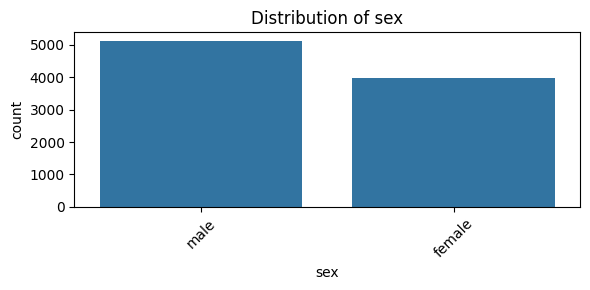


Distribution of race:


,count,percent
race,,
white,7191,78.98
black,1391,15.28
hispanic,290,3.19
other,112,1.23
asian,79,0.87
NaN,42,0.46


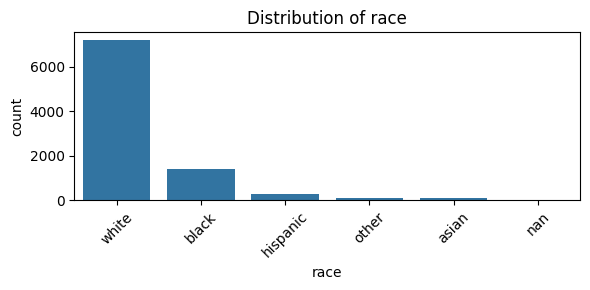


Distribution of dzclass:


,count,percent
dzclass,,
ARF/MOSF,4227,46.43
COPD/CHF/Cirrhosis,2862,31.43
Cancer,1420,15.60
Coma,596,6.55


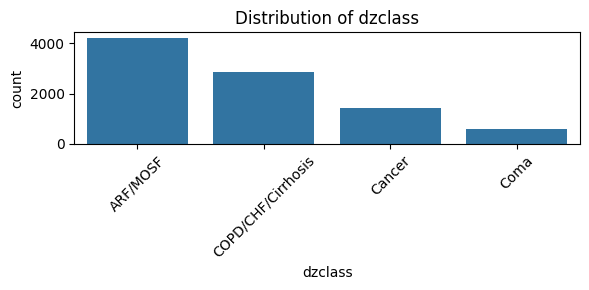


Distribution of dzgroup:


,count,percent
dzgroup,,
ARF/MOSF w/Sepsis,3515,38.61
CHF,1387,15.23
COPD,967,10.62
Lung Cancer,908,9.97
MOSF w/Malig,712,7.82
Coma,596,6.55
Colon Cancer,512,5.62
Cirrhosis,508,5.58


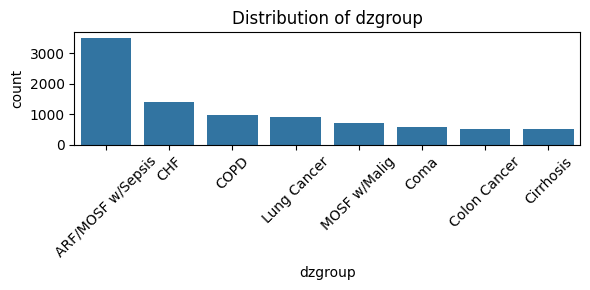


Distribution of income:


,count,percent
income,,
NaN,2982,32.75
under $11k,2855,31.36
$11-$25k,1527,16.77
$25-$50k,1057,11.61
>$50k,684,7.51


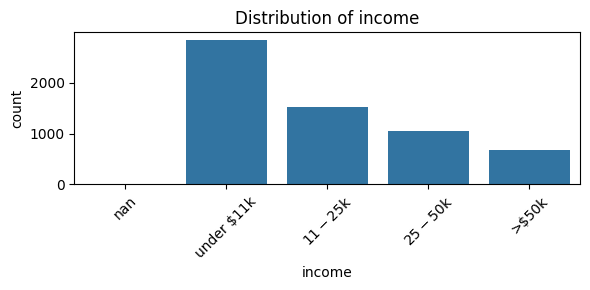


Distribution of dnr:


,count,percent
dnr,,
no dnr,5880,64.58
dnr after sadm,2956,32.47
dnr before sadm,239,2.62
NaN,30,0.33


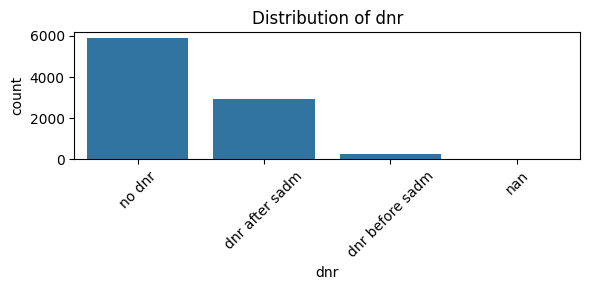


Distribution of sfdm2:


,count,percent
sfdm2,,
<2 mo. follow-up,3123,34.30
no(M2 and SIP pres),3061,33.62
NaN,1400,15.38
adl>=4 (>=5 if sur),916,10.06
SIP>=30,564,6.19
Coma or Intub,41,0.45


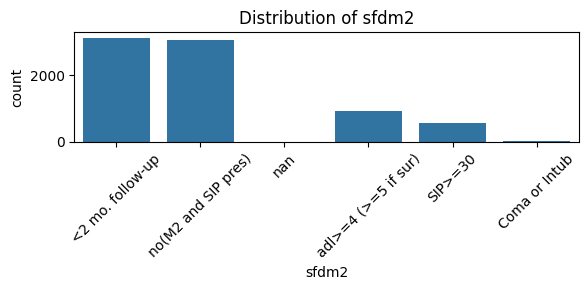

In [21]:
#############################################
# check data quality aspects
#############################################

dq_code_writer = student_a

start_time_dq = now()

# missing value analysis

print("\n Missing value analysis: ")

missing_counts = data.isna().sum()
missing_pct = (missing_counts / len(data)) * 100

missing_summary = (
    pd.DataFrame({
        "n_missing": missing_counts,
        "missing_%": missing_pct
    })
    .sort_values("missing_%", ascending=False)
    .round(2)
)

display(missing_summary)

# outlier detection 

print("\n Outlier detection (IQR-based) for numeric vars:")

outlier_rows = []

for col in num_cols:
    s = data[col].dropna()

    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    mask_out = (s < lower) | (s > upper)
    n_out = mask_out.sum()

    outlier_rows.append({
        "attribute": col,
        "n_outliers": int(n_out),
        "outlier_%": float(n_out / len(s) * 100),
        "min": float(s.min()),
        "q1": float(q1),
        "median": float(s.median()),
        "q3": float(q3),
        "max": float(s.max())
    })

outlier_summary = pd.DataFrame(outlier_rows).sort_values("outlier_%", ascending=False).round(2)
display(outlier_summary)

# uneven check: distribution of categorical vars

print("\nUneven check: Distribution of categorical vars:")

# key attributes
key_categoricals = ["sex", "race", "dzclass", "dzgroup", "income", "dnr", "sfdm2"]
key_categoricals = [c for c in key_categoricals]

for col in key_categoricals:
    vc = data[col].value_counts(dropna=False)
    dist = pd.DataFrame({
        "count": vc,
        "percent": (vc / len(data) * 100).round(2)
    })
    print(f"\nDistribution of {col}:")
    display(dist)

    end_time_dq = now()

    # bar plot for visual analysis
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, data=data, order=vc.index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [22]:
#############################################
# Documentation of 2 c
#############################################

# 1. Executor
dq_ass_uuid_executor = "c9d7790e-8ad3-4b97-9ce3-4ea1d912e18a"   # generate once
compute_data_quality_executor = [
    f':compute_data_quality prov:qualifiedAssociation :{dq_ass_uuid_executor} .',
    f':{dq_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dq_ass_uuid_executor} rdf:type prov:Association .',
    f':{dq_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(compute_data_quality_executor, prefixes=prefixes)

# 2. Writer
dq_ass_uuid_writer = "f4f65de7-014b-4cab-9e99-08e1e0e3423c"   # generate once
data_quality_comment = """
MISSING SUMMARY
"""

# 3. Activity: Analyze data quality aspects 
data_quality_activity = [
    ':data_quality_analysis rdf:type prov:Activity .',
    ':data_quality_analysis sc:isPartOf :data_understanding_phase .',
    f':data_quality_analysis rdfs:comment """{data_quality_comment}""" .',
    f':data_quality_analysis prov:startedAtTime "{start_time_dq}"^^xsd:dateTime .',
    f':data_quality_analysis prov:endedAtTime "{end_time_dq}"^^xsd:dateTime .',
    f':data_quality_analysis prov:qualifiedAssociation :{dq_ass_uuid_writer} .',
    f':{dq_ass_uuid_writer} prov:agent :{dq_code_writer} .',
    f':{dq_ass_uuid_writer} rdf:type prov:Association .',
    f':{dq_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':data_quality_analysis prov:used :data .',
    ':data_quality_report rdf:type prov:Entity .',
    ':data_quality_report rdfs:label "Data quality report" .',
    ':data_quality_report prov:wasGeneratedBy :data_quality_analysis .',
]
engine.insert(data_quality_activity, prefixes=prefixes)

# 4. Activity: Inspecting the data quality properties and taking decisions on what to do
dq_insp_ass_uuid_executor = "bb3e8b38-28c1-44cd-8a9a-9846a0c21352"   # generate once

data_quality_decisions = """
MISSING DECISIONS
"""

inspect_data_quality_activity = [
    ':inspect_data_quality rdf:type prov:Activity .',
    ':inspect_data_quality sc:isPartOf :data_understanding_phase .',
    f':inspect_data_quality rdfs:comment """Reviewing the data quality aspects and deriving decisions for data preparation.""" .',
    f':inspect_data_quality prov:startedAtTime "{start_time_dq}"^^xsd:dateTime .',
    f':inspect_data_quality prov:endedAtTime "{end_time_dq}"^^xsd:dateTime .',
    f':inspect_data_quality prov:qualifiedAssociation :{dq_insp_ass_uuid_executor} .',
    f':{dq_insp_ass_uuid_executor} prov:agent :{student_a} .',
    f':{dq_insp_ass_uuid_executor} rdf:type prov:Association .',
    f':{dq_insp_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_data_quality prov:used :data_quality_report .',
    ':data_quality_decision rdf:type prov:Entity .',
    ':data_quality_decision rdfs:label "Decisions from Data Quality Inspection" .',
    f':data_quality_decision rdfs:comment """{data_quality_decisions}""" .',
    ':data_quality_decision prov:wasGeneratedBy :inspect_data_quality .',
]
engine.insert(inspect_data_quality_activity, prefixes=prefixes)

**Continue with other tasks of the Data Understanding phase such as checking the distribution, skewness, plausibility of values, etc...**

## Data Preparation

In [23]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

# Task 3a.a: Reducing dataset

In [24]:
# Reduce dataset

dp_code_writer = student_b
dp_code_executor = student_b

start_time_reduce = now()

columns_keep = ["slos", "ca", "dementia", "diabetes", "dzclass", "dzgroup", "income", "race", "sex", 
                "num.co", "age", "edu", "hday", "aps", "scoma", "sps", "alb", "bili", "bun", "crea", 
                "glucose", "hrt", "meanbp", "pafi", "ph", "resp", "sod", "temp", "urine", "wblc", 
                "adlp", "adls", "adlsc"]

columns_exist = [col for col in columns_keep if col in data.columns]

columns_missing = list(set(columns_keep) - set(columns_exist))

# warning if columns were not found
if columns_missing: 
    print("WARNING! These columns were not found:", columns_missing)

#specify reduced dataset
data = data[columns_exist]

data.head()

end_time_reduce = now()


In [25]:
# Documentation of 3 a

# 1. Executor
dp_ass_uuid_executor = "b2f9a1cb-1d24-4d63-97c0-92ac34e514cd"   # generate once

reduce_dataset_executor = [
    f':reduce_dataset prov:qualifiedAssociation :{dp_ass_uuid_executor} .',
    f':{dp_ass_uuid_executor} prov:agent :{student_b} .',
    f':{dp_ass_uuid_executor} rdf:type prov:Association .',
    f':{dp_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(reduce_dataset_executor, prefixes=prefixes)

# 2. Writer
dp_ass_uuid_writer = "13f89d4f-668b-4d1f-b0c6-ae347d5fd202"

dp_comment = """
This activity reduced the original SUPPORT2 dataset to a subset of clinically relevant 
attributes. Missing columns were reported, and only the existing specified columns were kept.
"""

# 3. Activity: reduce dataset
reduce_dataset_activity = [
    ':reduce_dataset rdf:type prov:Activity .',
    ':reduce_dataset sc:isPartOf :data_preparation_phase .',
    ':reduce_dataset rdfs:comment "Data Preparation" .',
    f':reduce_dataset rdfs:comment """{dp_comment}""" .',
    f':reduce_dataset prov:startedAtTime "{start_time_reduce}"^^xsd:dateTime .',
    f':reduce_dataset prov:endedAtTime "{end_time_reduce}"^^xsd:dateTime .',

    # writer association
    f':reduce_dataset prov:qualifiedAssociation :{dp_ass_uuid_writer} .',
    f':{dp_ass_uuid_writer} prov:agent :{dp_code_writer} .',
    f':{dp_ass_uuid_writer} rdf:type prov:Association .',
    f':{dp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # input and output
    ':reduce_dataset prov:used :data .',
    ':reduced_dataset rdf:type prov:Entity .',
    ':reduced_dataset rdfs:label "Reduced SUPPORT2 Dataset" .',
    ':reduced_dataset prov:wasGeneratedBy :reduce_dataset .',
]

engine.insert(reduce_dataset_activity, prefixes=prefixes)

# Task 3a.b: Splitting dataset

In [26]:
# Train-Test Split (70% train, 30% test)

dp_code_writer = student_b
dp_code_executor = student_b

start_time_split = now()

# shuffle data
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# calculate split index for 70%
split_idx = int(0.70 * len(data_shuffled))

# split
train_data = data_shuffled.iloc[:split_idx]
test_data  = data_shuffled.iloc[split_idx:]

# separate features (X) and target (y)
X_train = train_data.drop(columns=["slos"])
y_train = train_data["slos"]

X_test = test_data.drop(columns=["slos"])
y_test = test_data["slos"]

print("Train shape (number of rows, number of feature columns):", X_train.shape)
print("Test shape (number of rows, number of feature columns):", X_test.shape)

end_time_split = now()

Train shape (number of rows, number of feature columns): (6373, 32)
Test shape (number of rows, number of feature columns): (2732, 32)


In [27]:
# Documentation of 3 b

# 1. Executor association
split_ass_uuid_executor = "d3a09cf4-2d89-4a89-bb8a-9aef72ce7e12"   # generate once, keep stable

train_test_split_executor = [
    f':train_test_split prov:qualifiedAssociation :{split_ass_uuid_executor} .',
    f':{split_ass_uuid_executor} prov:agent :{dp_code_executor} .',
    f':{split_ass_uuid_executor} rdf:type prov:Association .',
    f':{split_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(train_test_split_executor, prefixes=prefixes)


# 2. Writer association
split_ass_uuid_writer = "ac70bf09-b7ba-4c43-9ed2-cc6d4b51eb11"

split_comment = """
Performed a reproducible 70/30 train-test split:
- Shuffled dataset with random_state=42 to ensure deterministic reproducibility.
- Split rows into 70% training and 30% test.
- Extracted feature matrices (X_train, X_test) and target vectors (y_train, y_test).
"""


# 3. Activity + Entities
train_test_split_activity = [
    ':train_test_split rdf:type prov:Activity .',
    ':train_test_split sc:isPartOf :data_preparation_phase .',
    ':train_test_split rdfs:comment "Data Preparation" .',
    f':train_test_split rdfs:comment """{split_comment}""" .',
    f':train_test_split prov:startedAtTime "{start_time_split}"^^xsd:dateTime .',
    f':train_test_split prov:endedAtTime "{end_time_split}"^^xsd:dateTime .',

    # writer association
    f':train_test_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{dp_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # input
    ':train_test_split prov:used :data .',

    # outputs
    ':train_data rdf:type prov:Entity .',
    ':train_data rdfs:label "Training Dataset (70%)" .',
    ':train_data prov:wasGeneratedBy :train_test_split .',

    ':test_data rdf:type prov:Entity .',
    ':test_data rdfs:label "Test Dataset (30%)" .',
    ':test_data prov:wasGeneratedBy :train_test_split .',

    ':X_train rdf:type prov:Entity .',
    ':X_train rdfs:label "Training Features (X_train)" .',
    ':X_train prov:wasGeneratedBy :train_test_split .',

    ':y_train rdf:type prov:Entity .',
    ':y_train rdfs:label "Training Target (y_train)" .',
    ':y_train prov:wasGeneratedBy :train_test_split .',

    ':X_test rdf:type prov:Entity .',
    ':X_test rdfs:label "Test Features (X_test)" .',
    ':X_test prov:wasGeneratedBy :train_test_split .',

    ':y_test rdf:type prov:Entity .',
    ':y_test rdfs:label "Test Target (y_test)" .',
    ':y_test prov:wasGeneratedBy :train_test_split .',
]

engine.insert(train_test_split_activity, prefixes=prefixes)

# Task 3a.c: Imputing missing values

In [28]:
# 3c (A): Impute missing values from train data

dp_code_writer = student_b
dp_code_executor = student_b

start_time_mva_before = now()

# missing value analysis
print("\n Missing value analysis: ")

missing_counts = X_train.isna().sum()
missing_pct = (missing_counts / len(X_train)) * 100

missing_summary_train = (
    pd.DataFrame({
        "n_missing": missing_counts,
        "missing_%": missing_pct
    })
    .sort_values("missing_%", ascending=False)
    .round(2)
)

display(missing_summary_train)

end_time_mva_before = now()


 Missing value analysis: 


,n_missing,missing_%
adlp,3941,61.84
urine,3421,53.68
glucose,3150,49.43
bun,3049,47.84
alb,2368,37.16
income,2061,32.34
adls,1978,31.04
bili,1811,28.42
pafi,1616,25.36
ph,1586,24.89


In [29]:
# Documentation of 3 c (A)

# 1. Executor
mva_before_ass_uuid_executor = "2b3a1b5f-8b45-4e84-9ffa-b8962336df73"   # generate once, keep constant

mva_before_executor = [
    f':missing_value_analysis_before prov:qualifiedAssociation :{mva_before_ass_uuid_executor} .',
    f':{mva_before_ass_uuid_executor} prov:agent :{dp_code_executor} .',
    f':{mva_before_ass_uuid_executor} rdf:type prov:Association .',
    f':{mva_before_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(mva_before_executor, prefixes=prefixes)

# 2. Writer
mva_before_ass_uuid_writer = "7f989f92-86cb-4c46-9f86-1826cac70a14"   # generate once

mva_before_comment = """
Performed missing-value analysis on X_train before imputation.
Computed missing counts and percentages for all attributes and 
generated the sorted missing_summary_train table used to guide 
subsequent imputation decisions.
"""

# 3. Activity
mva_before_activity = [
    ':missing_value_analysis_before rdf:type prov:Activity .',
    ':missing_value_analysis_before sc:isPartOf :data_preparation_phase .',
    ':missing_value_analysis_before rdfs:comment "Data Preparation" .',
    f':missing_value_analysis_before rdfs:comment """{mva_before_comment}""" .',
    f':missing_value_analysis_before prov:startedAtTime "{start_time_mva_before}"^^xsd:dateTime .',
    f':missing_value_analysis_before prov:endedAtTime "{end_time_mva_before}"^^xsd:dateTime .',

    # writer association
    f':missing_value_analysis_before prov:qualifiedAssociation :{mva_before_ass_uuid_writer} .',
    f':{mva_before_ass_uuid_writer} prov:agent :{dp_code_writer} .',
    f':{mva_before_ass_uuid_writer} rdf:type prov:Association .',
    f':{mva_before_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # input
    ':missing_value_analysis_before prov:used :X_train .',

    # output entity
    ':missing_summary_train rdf:type prov:Entity .',
    ':missing_summary_train rdfs:label "Missing Value Summary (Before Imputation)" .',
    ':missing_summary_train prov:wasGeneratedBy :missing_value_analysis_before .',
]

engine.insert(mva_before_activity, prefixes=prefixes)

In [30]:
# 3c (B): Impute recommended default missing values 

dp_code_writer = student_b
dp_code_executor = student_b

start_time_rdi = now() # rdi = recommended default implementation

# recommended fill-in values
recommended_defaults = {
    "alb": 3.5,
    "pafi": 333.3,
    "bili": 1.01,
    "crea": 1.01,
    "bun": 6.51,
    "wblc": 9,
    "urine": 2502
}

for col, default_val in recommended_defaults.items():
    if col in X_train.columns:
        X_train[col] = X_train[col].fillna(default_val)

end_time_rdi = now()

In [31]:
# Documentation of 3 c (B)

# 1. Executor
rdi_ass_uuid_executor = "9d76cbe0-5fed-4d21-bc44-b14571e1937e"   # generate once, keep unchanged

rdi_executor = [
    f':recommended_default_imputation prov:qualifiedAssociation :{rdi_ass_uuid_executor} .',
    f':{rdi_ass_uuid_executor} prov:agent :{dp_code_executor} .',
    f':{rdi_ass_uuid_executor} rdf:type prov:Association .',
    f':{rdi_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(rdi_executor, prefixes=prefixes)

# 2. Writer
rdi_ass_uuid_writer = "b7954df1-1c07-4c91-8088-1dfcdeb29261"   # generate once

rdi_comment = """
Imputed missing physiological and laboratory values in X_train 
using clinically recommended constants for the following attributes:
alb, pafi, bili, crea, bun, wblc, urine.
This step ensures medically plausible replacements rather than 
statistical estimates.
"""

# 3. Activity
rdi_activity = [
    ':recommended_default_imputation rdf:type prov:Activity .',
    ':recommended_default_imputation sc:isPartOf :data_preparation_phase .',
    ':recommended_default_imputation rdfs:comment "Data Preparation" .',
    f':recommended_default_imputation rdfs:comment """{rdi_comment}""" .',
    f':recommended_default_imputation prov:startedAtTime "{start_time_rdi}"^^xsd:dateTime .',
    f':recommended_default_imputation prov:endedAtTime "{end_time_rdi}"^^xsd:dateTime .',

    # writer association
    f':recommended_default_imputation prov:qualifiedAssociation :{rdi_ass_uuid_writer} .',
    f':{rdi_ass_uuid_writer} prov:agent :{dp_code_writer} .',
    f':{rdi_ass_uuid_writer} rdf:type prov:Association .',
    f':{rdi_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # input
    ':recommended_default_imputation prov:used :X_train .',

    # output entity
    ':X_train_after_recommended_defaults rdf:type prov:Entity .',
    ':X_train_after_recommended_defaults rdfs:label "X_train after recommended default imputations" .',
    ':X_train_after_recommended_defaults prov:wasGeneratedBy :recommended_default_imputation .',
]

engine.insert(rdi_activity, prefixes=prefixes)

In [32]:
# 3c (C): Drop rows with low % of missing values

dp_code_writer = student_b
dp_code_executor = student_b

start_time_drop = now()

cols_drop_missing = ["race", "sod", "meanbp", "hrt", "resp", "temp"]

# rows before dropping
rows_before = X_train.shape[0]

# drop rows where any of these columns have NA
mask_missing = X_train[cols_drop_missing].isna().any(axis=1)
X_train = X_train[~mask_missing]
y_train = y_train[~mask_missing]   # removes same rows from target

# rows after dropping
rows_after = X_train.shape[0]

print(f"Rows before dropping: {rows_before}")
print(f"Rows after dropping:  {rows_after}")
print(f"Dropped rows:         {rows_before - rows_after}")

end_time_drop = now()

Rows before dropping: 6373
Rows after dropping:  6343
Dropped rows:         30


In [ ]:
# Documentation of 3 c (C)

# 1. Executor
drop_ass_uuid_executor = "d291d7e5-70e7-4f16-9f92-5acf2a633271"  # new UUID

drop_rows_executor = [
    f':drop_low_missing_rows_activity_2025a prov:qualifiedAssociation :{drop_ass_uuid_executor} .',
    f':{drop_ass_uuid_executor} prov:agent :{dp_code_executor} .',
    f':{drop_ass_uuid_executor} rdf:type prov:Association .',
    f':{drop_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

# engine.insert(drop_rows_executor, prefixes=prefixes)

# 2. Writer
drop_ass_uuid_writer = "399dec5d-7808-485c-97ff-561422cb4b4b"   # new UUID

drop_comment = """
Dropped rows in X_train and y_train where missing values appeared in:
race, sod, meanbp, hrt, resp, temp.
This removed incomplete cases with minimal information loss.
"""

# 3. Activity
drop_activity = [
    ':drop_low_missing_rows_activity_2025a rdf:type prov:Activity .',
    ':drop_low_missing_rows_activity_2025a sc:isPartOf :data_preparation_phase .',
    ':drop_low_missing_rows_activity_2025a rdfs:comment "Data Preparation" .',
    f':drop_low_missing_rows_activity_2025a rdfs:comment """{drop_comment}""" .',
    f':drop_low_missing_rows_activity_2025a prov:startedAtTime "{start_time_drop}"^^xsd:dateTime .',
    f':drop_low_missing_rows_activity_2025a prov:endedAtTime "{end_time_drop}"^^xsd:dateTime .',

    # writer association
    f':drop_low_missing_rows_activity_2025a prov:qualifiedAssociation :{drop_ass_uuid_writer} .',
    f':{drop_ass_uuid_writer} prov:agent :{dp_code_writer} .',
    f':{drop_ass_uuid_writer} rdf:type prov:Association .',
    f':{drop_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # inputs
    ':drop_low_missing_rows_activity_2025a prov:used :X_train .',
    ':drop_low_missing_rows_activity_2025a prov:used :y_train .',

    # outputs
    ':X_train_after_row_drop_2025a rdf:type prov:Entity .',
    ':X_train_after_row_drop_2025a rdfs:label "X_train after dropping rows with missing values (final)" .',
    ':X_train_after_row_drop_2025a prov:wasGeneratedBy :drop_low_missing_rows_activity_2025a .',

    ':y_train_after_row_drop_2025a rdf:type prov:Entity .',
    ':y_train_after_row_drop_2025a rdfs:label "y_train after dropping rows (final)" .',
    ':y_train_after_row_drop_2025a prov:wasGeneratedBy :drop_low_missing_rows_activity_2025a .',
]

engine.insert(drop_activity, prefixes=prefixes)

HTTPError: HTTP Error 403: Forbidden

In [ ]:
# 3c (D): Impute missing values for income

dp_code_writer = student_b
dp_code_executor = student_b

start_time_income = now()

# replace missing values in income with the category 'unknown'
X_train["income"] = X_train["income"].fillna("unknown")

print(X_train["income"].value_counts(dropna=False))

end_time_income = now()

In [ ]:
# Documentation of 3 c (D)

# 1. Executor
income_ass_uuid_executor = "cc7d2342-4df4-4c0f-b699-fefb8380a8c7"   # generate once

income_imputation_executor = [
    f':income_missing_imputation prov:qualifiedAssociation :{income_ass_uuid_executor} .',
    f':{income_ass_uuid_executor} prov:agent :{dp_code_executor} .',
    f':{income_ass_uuid_executor} rdf:type prov:Association .',
    f':{income_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(income_imputation_executor, prefixes=prefixes)

# 2. Writer
income_ass_uuid_writer = "c1b40b72-12e8-4f99-be92-979fc59dcf55"   # generate once

income_comment = """
Imputed missing values in X_train['income'] by replacing NA values with 
the new category 'unknown'. This preserves all observations while 
explicitly marking missing socioeconomic information.
"""

# 3. Activity
income_imputation_activity = [
    ':income_missing_imputation rdf:type prov:Activity .',
    ':income_missing_imputation sc:isPartOf :data_preparation_phase .',
    ':income_missing_imputation rdfs:comment "Data Preparation" .',
    f':income_missing_imputation rdfs:comment """{income_comment}""" .',
    f':income_missing_imputation prov:startedAtTime "{start_time_income}"^^xsd:dateTime .',
    f':income_missing_imputation prov:endedAtTime "{end_time_income}"^^xsd:dateTime .',

    # writer association
    f':income_missing_imputation prov:qualifiedAssociation :{income_ass_uuid_writer} .',
    f':{income_ass_uuid_writer} prov:agent :{dp_code_writer} .',
    f':{income_ass_uuid_writer} rdf:type prov:Association .',
    f':{income_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # input
    ':income_missing_imputation prov:used :X_train .',

    # output entity
    ':X_train_after_income_imputation rdf:type prov:Entity .',
    ':X_train_after_income_imputation rdfs:label "X_train after income missing-value imputation" .',
    ':X_train_after_income_imputation prov:wasGeneratedBy :income_missing_imputation .',
]

engine.insert(income_imputation_activity, prefixes=prefixes)

In [ ]:
# 3c (E): Impute missing values with mean value

dp_code_writer = student_b
dp_code_executor = student_b

start_time_mean = now()

mean_impute_cols = ["adlp", "adls", "ph", "glucose"]

for col in mean_impute_cols:

    # missing flag
    X_train[col + "_missing"] = X_train[col].isna().astype(int)

    mean_value = X_train[col].mean()
    X_train[col] = X_train[col].fillna(mean_value)

print(X_train[mean_impute_cols + [c + "_missing" for c in mean_impute_cols]].head())

end_time_mean = now()

In [ ]:
# Documentation of 3 c (E)

# 1. Executor
mean_ass_uuid_executor = "e5a280f1-9f5d-4d17-be26-f9ca86846a53"   # generate once & keep stable

mean_imputation_executor = [
    f':mean_imputation prov:qualifiedAssociation :{mean_ass_uuid_executor} .',
    f':{mean_ass_uuid_executor} prov:agent :{dp_code_executor} .',
    f':{mean_ass_uuid_executor} rdf:type prov:Association .',
    f':{mean_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(mean_imputation_executor, prefixes=prefixes)

# 2. Writer
mean_ass_uuid_writer = "8fa1eacb-92b5-4a14-905e-d6ab29a28f62"   # generate once & keep stable

mean_imputation_comment = """
Created binary missing-value flags and applied mean imputation for the 
following variables in X_train: adlp, adls, ph, glucose.
For each variable, a new <col>_missing flag was generated prior to 
replacing missing values with the column mean.
"""

# 3. Activity
mean_imputation_activity = [
    ':mean_imputation rdf:type prov:Activity .',
    ':mean_imputation sc:isPartOf :data_preparation_phase .',
    ':mean_imputation rdfs:comment "Data Preparation" .',
    f':mean_imputation rdfs:comment """{mean_imputation_comment}""" .',
    f':mean_imputation prov:startedAtTime "{start_time_mean}"^^xsd:dateTime .',
    f':mean_imputation prov:endedAtTime "{end_time_mean}"^^xsd:dateTime .',

    # writer association
    f':mean_imputation prov:qualifiedAssociation :{mean_ass_uuid_writer} .',
    f':{mean_ass_uuid_writer} prov:agent :{dp_code_writer} .',
    f':{mean_ass_uuid_writer} rdf:type prov:Association .',
    f':{mean_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # input
    ':mean_imputation prov:used :X_train .',

    # outputs
    ':X_train_after_mean_imputation rdf:type prov:Entity .',
    ':X_train_after_mean_imputation rdfs:label "X_train after mean imputation & missing flags" .',
    ':X_train_after_mean_imputation prov:wasGeneratedBy :mean_imputation .',
]

engine.insert(mean_imputation_activity, prefixes=prefixes)

In [ ]:
# 3c (F): Impute missing values with median value

dp_code_writer = student_b
dp_code_executor = student_b

start_time_median = now()

# missing flag
X_train["edu_missing"] = X_train["edu"].isna().astype(int)

edu_median = X_train["edu"].median()
X_train["edu"] = X_train["edu"].fillna(edu_median)

print("Median used for edu:", edu_median)
print("Remaining missing values in edu:", X_train["edu"].isna().sum())

end_time_median = now()

In [ ]:
# Documentation of 3 c (F)

# 1. Executor
median_ass_uuid_executor = "92f08350-e72e-4eaf-8ad1-3b71ea4105b3"   # generate once & keep stable

median_imputation_executor = [
    f':median_imputation prov:qualifiedAssociation :{median_ass_uuid_executor} .',
    f':{median_ass_uuid_executor} prov:agent :{dp_code_executor} .',
    f':{median_ass_uuid_executor} rdf:type prov:Association .',
    f':{median_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(median_imputation_executor, prefixes=prefixes)

# 2. Writer
median_ass_uuid_writer = "fba60a90-0c87-4b0a-9c30-a89f0562ba86"   # generate once

median_imputation_comment = """
Created a binary missing-value flag for X_train['edu'] and imputed the 
missing values using the median of the observed values in the training data. 
This preserves robustness against skewed distributions in education levels.
"""

# 3. Activity
median_imputation_activity = [
    ':median_imputation rdf:type prov:Activity .',
    ':median_imputation sc:isPartOf :data_preparation_phase .',
    ':median_imputation rdfs:comment "Data Preparation" .',
    f':median_imputation rdfs:comment """{median_imputation_comment}""" .',
    f':median_imputation prov:startedAtTime "{start_time_median}"^^xsd:dateTime .',
    f':median_imputation prov:endedAtTime "{end_time_median}"^^xsd:dateTime .',

    # writer association
    f':median_imputation prov:qualifiedAssociation :{median_ass_uuid_writer} .',
    f':{median_ass_uuid_writer} prov:agent :{dp_code_writer} .',
    f':{median_ass_uuid_writer} rdf:type prov:Association .',
    f':{median_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # inputs
    ':median_imputation prov:used :X_train .',

    # output entity
    ':X_train_after_median_imputation rdf:type prov:Entity .',
    ':X_train_after_median_imputation rdfs:label "X_train after median imputation for edu" .',
    ':X_train_after_median_imputation prov:wasGeneratedBy :median_imputation .',
]

engine.insert(median_imputation_activity, prefixes=prefixes)

In [ ]:
# 3c (G): Missing value analysis (after all imputations)

dp_code_writer = student_b
dp_code_executor = student_b

start_time_mva_after = now()

print("\n Missing value analysis: ")

missing_counts = X_train.isna().sum()
missing_pct = (missing_counts / len(X_train)) * 100

missing_summary_train = (
    pd.DataFrame({
        "n_missing": missing_counts,
        "missing_%": missing_pct
    })
    .sort_values("missing_%", ascending=False)
    .round(2)
)

display(missing_summary_train)

end_time_mva_after = now()

In [ ]:
# Documentation of 3 c (G)

# 1. Executor
mva_after_ass_uuid_executor = "1d180cbd-b673-479f-bf33-3d2e5d8bfa32"   # generate once, keep stable

mva_after_executor = [
    f':missing_value_analysis_after prov:qualifiedAssociation :{mva_after_ass_uuid_executor} .',
    f':{mva_after_ass_uuid_executor} prov:agent :{dp_code_executor} .',
    f':{mva_after_ass_uuid_executor} rdf:type prov:Association .',
    f':{mva_after_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(mva_after_executor, prefixes=prefixes)

# 2. Writer
mva_after_ass_uuid_writer = "e9ae9a1e-3cf6-4ef8-a7b3-78cf5bde5737"   # generate once

mva_after_comment = """
Performed a second missing-value analysis on X_train after all 
imputation steps were completed. Computed missing counts and 
percentages for all variables and generated the updated 
missing_summary_train table to verify that outstanding missing 
values have been resolved.
"""

# 3. Activity
mva_after_activity = [
    ':missing_value_analysis_after rdf:type prov:Activity .',
    ':missing_value_analysis_after sc:isPartOf :data_preparation_phase .',
    ':missing_value_analysis_after rdfs:comment "Data Preparation" .',
    f':missing_value_analysis_after rdfs:comment """{mva_after_comment}""" .',
    f':missing_value_analysis_after prov:startedAtTime "{start_time_mva_after}"^^xsd:dateTime .',
    f':missing_value_analysis_after prov:endedAtTime "{end_time_mva_after}"^^xsd:dateTime .',

    # writer association
    f':missing_value_analysis_after prov:qualifiedAssociation :{mva_after_ass_uuid_writer} .',
    f':{mva_after_ass_uuid_writer} prov:agent :{dp_code_writer} .',
    f':{mva_after_ass_uuid_writer} rdf:type prov:Association .',
    f':{mva_after_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # input
    ':missing_value_analysis_after prov:used :X_train .',

    # output entity
    ':missing_summary_train_after rdf:type prov:Entity .',
    ':missing_summary_train_after rdfs:label "Missing Value Summary After Imputation" .',
    ':missing_summary_train_after prov:wasGeneratedBy :missing_value_analysis_after .',
]

engine.insert(mva_after_activity, prefixes=prefixes)

# Task 3a.d: Remove illegal outliers / impossible values

In [ ]:
# Outliers Strategy: keep outliers as they provide valuable clinical information
# Remove illegal data like outside of physiological limits or typo values (check from data understanding part)

# done before any encoding or scaling (should also be done before imputation)

# Task 3a.e: Log-transform selected skewed lab variables

In [ ]:
# transformations happen before sclaing and before encoding !
# user when distribution is right-skewed
# makes sense for our data set and ist most common transformation in medical data
# log-transform: bili, bun, crea, wblc, (optional) glucose
# possibly bin age into category if this makes sense for us (optional)

# avoid any other method !!!

# alternative: square-root transformation (but no need for sqrt in our data set), box-cox transformation (only works for positive values, more complex to interpret but not common on clinical ML, makes interpretation harder)

# GENERALLY: log transformation is usually applied to right-skewed numerical data where most patients have very low values but a few have extremely high values, this reduced the impact of outliers, etc. 

# Task 3a.f: Encode categorical variables (one-hot encoding)

In [ ]:
# must happen before standardization but after transformation
# encode: ca, dementia, diabetes, dzclass, dzgroup, income, race, sex

# one hot encoding creates binary columns and is best for our case as it makes no assumptions of order
# ordinal encoding is an alternative but it makes sense only if categories have natural order and the order has a meaning, e. g. income could be ordinal but other variables are not (race, sex, dzgroup, ca)

# one-hot encoding for all categorical variables and optionally ordinal encoding for income only

# Task 3a.g: Standardize numerical variables

In [ ]:
# standardize all numeric variables except slos (target)
# after imputation, log-transformation, encoding

# fit scaler on train only, apply to val/test

# GENERALLY: ensures all numerical variables are on the same scale, makes coefficients comparable

In [ ]:
#handle_outliers_code_writer = student_b
#def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
#    # REMOVE OUTLIERS
#    return df

#start_time_td = now()
#handle_outliers(data, outliers_report)
#end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

#ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
#handle_outliers_executor = [
#    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
#    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
#    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
#    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
#]
#engine.insert(handle_outliers_executor, prefixes=prefixes)

#td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
#td_comment = """
#Removing all outliers that were identifying in the Data Understanding Phase.
#"""
#handle_outliers_activity = [
#    ':handle_outliers rdf:type prov:Activity .',
#    ':handle_outliers sc:isPartOf :data_preparation_phase .',
#    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
#    f':handle_outliers rdfs:comment """{td_comment}""" .', 
#    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
#    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
#    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
#    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
#    f':{td_ass_uuid_writer} rdf:type prov:Association .',
#    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
#    ':handle_outliers prov:used :data .',
#    ':handle_outliers prov:used :outlier_decision .',
#    ':cleaned_data rdf:type prov:Entity .',
#    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
#    ':cleaned_data prov:wasDerivedFrom :data .',
#]
#engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [ ]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

# Task 3b: Alternative Pre-Processing Steps

In [ ]:
# OTHER PRE PROCESSING STEPS

# BINNING: turn continuous variables into categories, possible but only if medically useful --> causes information loss, use only if theres a good reason 
# (in our case this could be done for age but also does not really make sense + binning labs/vitals does not make sense for our case.

# SCALING/NORMALIZATION: standardization (necessary for some models), min-max scaling (possible, but should not be used as it distorts clinical meaning because values become relative to dataset)
# we should use standardization only

# Task 3c: Potential for Derived Attributes

In [ ]:
"""
We analyzed the potential for derived attributes in the SUPPORT2 dataset to evaluate whether
additional engineered features could meaningfully improve prediction of patient survival (slos).

Several types of derived attributes were considered:

1. Ratio variables:
   - BUN/Creatinine ratio, commonly used clinically to distinguish types of renal impairment.
   - PaO2/FiO2 ratio categories to measure severity of respiratory failure (e.g., ARDS classification).

2. Clinically meaningful binary flags:
   Examples include hyponatremia (sod < 135), acidosis (ph < 7.35), tachycardia (hrt > 130),
   hyperbilirubinemia (bili > 2 mg/dL), or fever (temp >= 38°C). Such variables convert continuous 
   values into interpretable risk markers.

3. Combined organ dysfunction indicators:
   For example, generating a derived variable that counts the number of organ systems failing based 
   on thresholds in bilirubin (liver), creatinine (kidney), pafi (lungs), or ph (metabolic function).
   This mirrors clinical scoring systems such as SOFA/APACHE.

4. Age groups:
   Transforming continuous age into clinically meaningful bins (e.g., <40, 40–60, 60–75, >75).

5. Interaction terms:
   Potential interactions such as age × APS, scoma × pafi, or cancer status × wblc.

6. Normalized lab values:
   Adjusting creatinine relative to age or sex.

Conclusion:
Although these derived attributes could provide additional signal, the SUPPORT2 dataset already 
contains several high-level clinical scores (e.g., APS, SCOMA, SPS). Given the assignment scope and 
the goal of maintaining interpretability, we decided not to create or apply any derived attributes. 
However, their potential value was documented as part of the Data Preparation analysis.

"""

# Task 3d: External Data Sources

In [ ]:
"""
We analyzed possible external data sources that could enrich the SUPPORT2 dataset and improve 
prediction of patient survival (slos). These additions are hypothetical and were not integrated due to 
scope and feasibility constraints of the assignment, but they demonstrate areas where additional 
context could meaningfully improve model performance.

1. Hospital-level data:
   Attributes such as ICU staffing ratios, number of ICU beds, availability of advanced life-support 
   technologies, or hospital size could influence patient outcomes. SUPPORT2 includes data from 
   five medical centers, but detailed resource information is missing.

2. Temporal variables:
   Useful additions include year of admission (care quality improved from 1989–1994), seasonality 
   (e.g., winter respiratory infections), and time-of-day admission (day vs night shifts).

3. Detailed comorbidity indices:
   SUPPORT2 only includes the number of comorbidities, not their nature or severity. External 
   scores such as the Charlson Comorbidity Index (CCI) or Elixhauser comorbidity groups could 
   improve the predictive accuracy and clinical relevance.

4. Socioeconomic and demographic context:
   ZIP-code linked socioeconomic indicators (e.g., income level, deprivation index) from U.S. Census 
   data could offer additional explanatory power, especially since income is an important predictor in 
   SUPPORT2 but is coarse-grained in the dataset.

5. Treatment/intervention data:
   Information such as mechanical ventilation, use of vasopressors, dialysis, or administered 
   medications (antibiotics, steroids) is absent but highly relevant in ICU mortality models.

6. Additional biomarker or genetic information:
   Hypothetical data such as inflammatory markers or genomic data would be beneficial but are 
   beyond the scope of this dataset.

Conclusion:
Several external data sources could improve the model's predictive performance or interpretability, 
particularly hospital-level data, treatment information, socioeconomic context, and detailed 
comorbidity profiles. However, due to dataset limitations and assignment requirements, these 
sources were not integrated.

"""

## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [ ]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [ ]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [ ]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [ ]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")